In [2]:
%pylab inline
from __future__ import print_function
from scipy import interpolate, signal
from time import *
from obspy import *
import numpy as np
import matplotlib.pylab as plt
import os
import glob
import csv
from obspy.core.utcdatetime import UTCDateTime
import urllib.request
from obspy.io.jaxa_moon.core import _read_jaxa_moon
from statistics import mode
from matplotlib import gridspec
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 4
plt.rcParams['lines.linewidth'] = 0.5

/Users/nunn/anaconda/envs/env_2/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/nunn/anaconda/envs/env_2/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


Diffusion Equation from Bastin et al (1971, Equation 2) 
\begin{equation}
I = \frac{A}{(kt)^{\frac{3}{2}}}\exp\left[ -\frac{r^2}{4kt} - \frac{2\pi ft}{Q} \right]
\end{equation}

In [3]:
# Constants from Latham 1970 (also used in Bastin 1971)
Q = 3600
k = 1.2e6 # m^2/s
# mean free path on the order of 300 m. 
A = 1

r = 100000 #m 
f = 0.45 # Hz

def diffusion_I_firstterm(t,A,k,r,f,Q):
    
    I = A/((k*t)**(3/2)) * np.exp(-((r**2)/(4*k*t)))
    return(I)
    
def diffusion_I(t,A,k,r,f,Q,normalized=False):
    
    I = A/((k*t)**(3/2)) * np.exp(-((r**2)/(4*k*t)) - ((2*np.pi*f*t)/Q))
    if normalized:
        max_I = np.nanmax(I)
        I = I/max_I
    return(I)

    
def diffusion_I_first_term(t,A,k,r,f,Q,normalized=False):
    
    I = np.exp(-((r**2)/(4*k*t)))
    if normalized:
        max_I = np.nanmax(I)
        I = I/max_I
    return(I)

def diffusion_I_second_term(t,A,k,r,f,Q,normalized=False):
    
    I = np.exp(-(2*np.pi*f*t)/Q)
    if normalized:
        max_I = np.nanmax(I)
        I = I/max_I
    return(I)

def diffusion_I_exponent(t,A,k,r,f,Q,normalized=False):
    
    I = np.exp(-((r**2)/(4*k*t)) - ((2*np.pi*f*t)/Q))
    if normalized:
        max_I = np.nanmax(I)
        I = I/max_I
    return(I)

def diffusion_I_outer(t,A,k,r,f,Q,normalized=False):
    
    I = A/((k*t)**(3/2))
    if normalized:
        max_I = np.nanmax(I)
        I = I/max_I
    return(I)

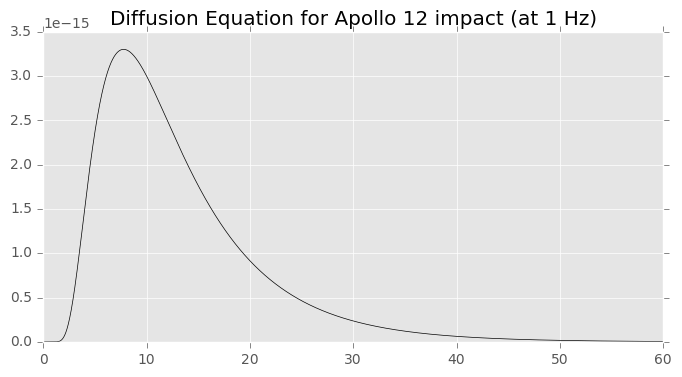

In [4]:
# Apollo 12 impact at 1 Hz 
fig, ax = plt.subplots(figsize=(8, 4))

ax2 = plt.subplot(1, 1, 1)
t = np.arange(0.5,3600)

ax2.plot(t/60.,diffusion_I(t,A=1,k=1.2e6,r=72*1000,f=1,Q=3600),color='k')
ax2.set_xlim(0,60)
plt.title('Diffusion Equation for Apollo 12 impact (at 1 Hz)')

plt.show()

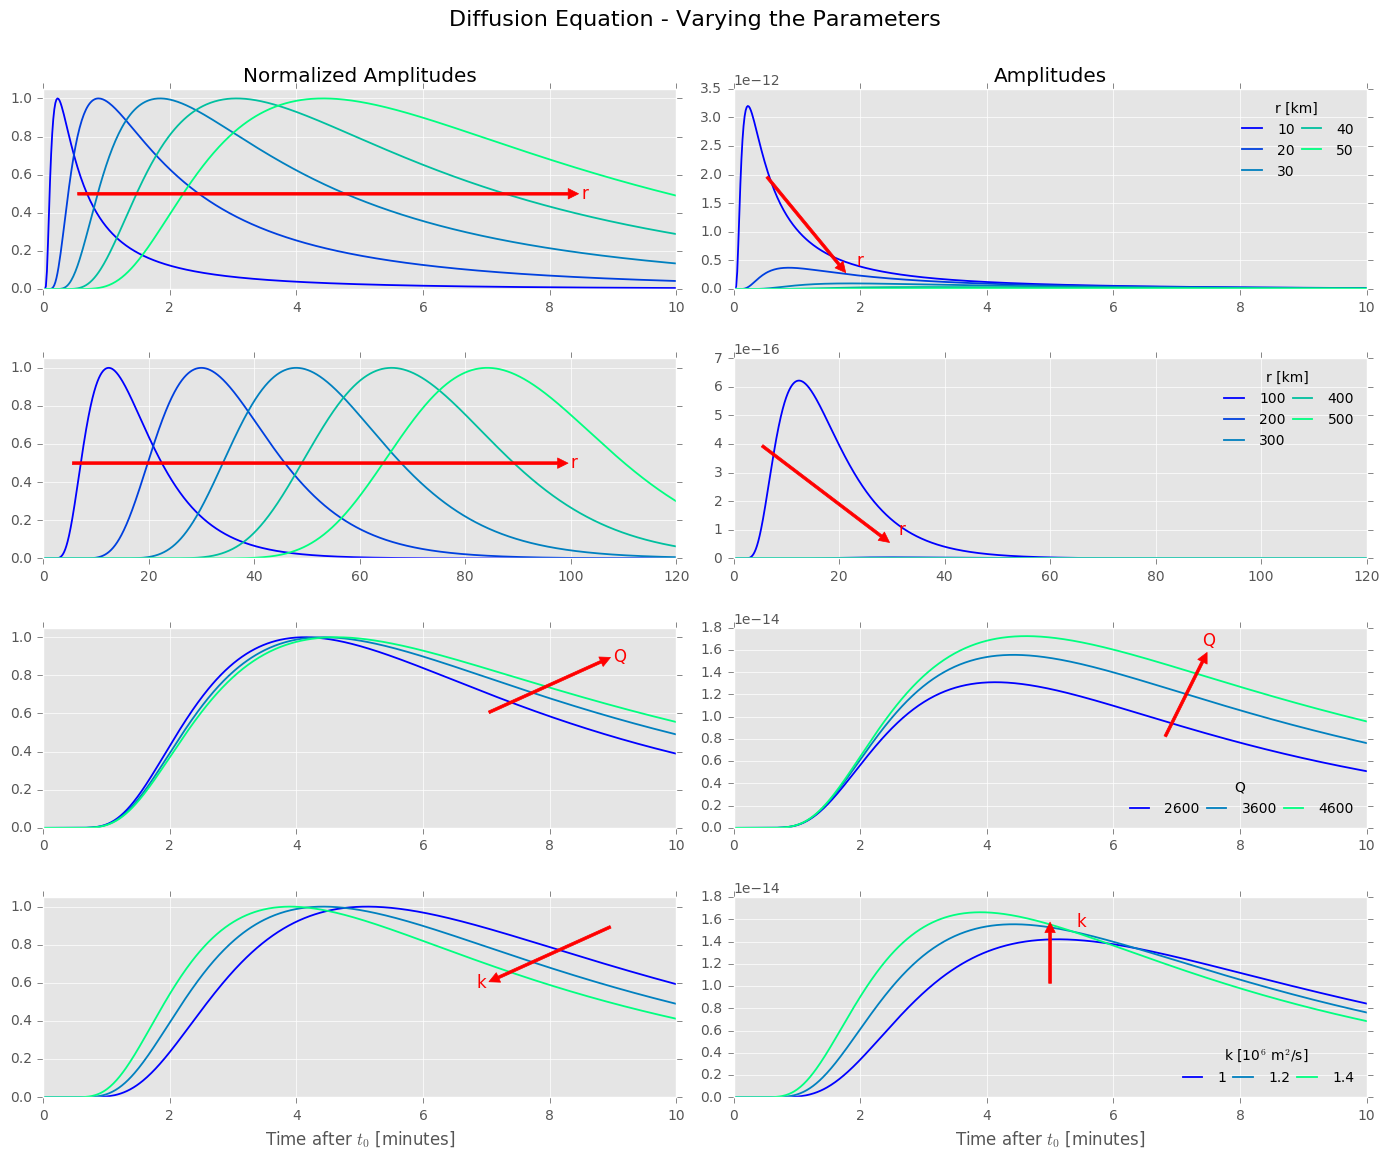

In [18]:
# plot how the parameters affect the results 
fig = plt.figure(figsize=(14, 14))
gs = gridspec.GridSpec(5,2)
# arrow options 
opt = dict(color='r', 
            arrowstyle = 'simple,head_width=.75,head_length=.75',
            connectionstyle = 'arc3,rad=0')

#####
ax1 = fig.add_subplot(gs[0])



t = np.arange(0.5,3600*3)
radii = [10, 20,  30, 40, 50]
colors = plt.cm.winter(np.linspace(0,1,len(radii)))

for i, r in enumerate(radii): 
    r = r * 1000
    ax1.plot(t/60,diffusion_I(t,A=1,k=1.2e6,r=r,f=1,Q=3600,
        normalized=True),color=colors[i],linewidth=1.3)
    
ax1.set_xlim(0,10)
ax1.set_ylim(0,1.05)

ax1.annotate('',xy=(8.5,0.5),xycoords='data',xytext =(0.5,0.5),
             arrowprops=opt,size=10)
ax1.text(8.5, 0.5, 'r', fontsize=12, color='r',horizontalalignment='left',
    verticalalignment='center')
ax1.set_title('Normalized Amplitudes')

#####
ax2 = fig.add_subplot(gs[1])

t = np.arange(0.5,3600*3)
radii = [10, 20,  30, 40, 50]
colors = plt.cm.winter(np.linspace(0,1,len(radii)))

for i, r in enumerate(radii): 
    rm = r * 1000
    ax2.plot(t/60,diffusion_I(t,A=1,k=1.2e6,r=rm,f=1,Q=3600,
        normalized=False),color=colors[i],linewidth=1.3,label=str(r))

ax2.set_xlim(0,10)
ax2.annotate('',xy=(1.8,0.25e-12),xycoords='data',xytext =(0.5,2e-12),
             arrowprops=opt,size=10)
ax2.text(2,0.5e-12, 'r', fontsize=12, color='r',horizontalalignment='center',
    verticalalignment='center')
ax2.legend(ncol=2,prop={'size': 10},title='r [km]',framealpha=0,columnspacing=0.2)
ax2.set_title('Amplitudes')

#####
ax3 = fig.add_subplot(gs[2])

t = np.arange(0.5,3600*3)
radii = [100, 200,  300, 400, 500]
colors = plt.cm.winter(np.linspace(0,1,len(radii)))

for i, r in enumerate(radii): 
    r = r * 1000
    ax3.plot(t/60,diffusion_I(t,A=1,k=1.2e6,r=r,f=1,Q=3600,
        normalized=True),color=colors[i],linewidth=1.3)
    
ax3.set_xlim(0,120)
ax3.set_ylim(0,1.05)
ax3.annotate('',xy=(100,0.5),xycoords='data',xytext =(5,0.5),
             arrowprops=opt,size=10)
ax3.text(100, 0.5, 'r', fontsize=12, color='r',horizontalalignment='left',
    verticalalignment='center')

#####
ax4 = fig.add_subplot(gs[3])

t = np.arange(0.5,3600*3)
radii = [100, 200,  300, 400, 500]
colors = plt.cm.winter(np.linspace(0,1,len(radii)))

for i, r in enumerate(radii): 
    rm = r * 1000
    ax4.plot(t/60,diffusion_I(t,A=1,k=1.2e6,r=rm,f=1,Q=3600,
        normalized=False),color=colors[i],linewidth=1.3,label=str(r))

    
ax4.set_xlim(0,120)
ax4.annotate('',xy=(30,0.5e-16),xycoords='data',xytext =(5,4e-16),
             arrowprops=opt,size=10)
ax4.text(32,1e-16, 'r', fontsize=12, color='r',horizontalalignment='center',
    verticalalignment='center')
ax4.legend(ncol=2,prop={'size': 10},title='r [km]',framealpha=0,columnspacing=0.2)

#####
ax5 = fig.add_subplot(gs[4])

t = np.arange(0.5,3600*3)
Qs = [2600, 3600, 4600]
colors = plt.cm.winter(np.linspace(0,1,len(Qs)))

for i, Q in enumerate(Qs): 
    ax5.plot(t/60,diffusion_I(t,A=1,k=1.2e6,r=50*1000,f=1,Q=Q,
        normalized=True),color=colors[i],linewidth=1.3)
    
ax5.set_xlim(0,10)
ax5.set_ylim(0,1.05)
ax5.annotate('',xy=(9,0.9),xycoords='data',xytext =(7,0.6),
             arrowprops=opt,size=10)
ax5.text(9, 0.9, 'Q', fontsize=12, color='r',horizontalalignment='left',
    verticalalignment='center')

#####
ax6 = fig.add_subplot(gs[5])

t = np.arange(0.5,3600*3)
Qs = [2600, 3600, 4600]
colors = plt.cm.winter(np.linspace(0,1,len(Qs)))

for i, Q in enumerate(Qs): 
    ax6.plot(t/60,diffusion_I(t,A=1,k=1.2e6,r=50*1000,f=1,Q=Q,
        normalized=False),color=colors[i],linewidth=1.3,label=str(Q))
    
ax6.set_xlim(0,10)
ax6.annotate('',xy=(7.5,1.6e-14),xycoords='data',xytext =(6.8,0.8e-14),
             arrowprops=opt,size=10)
ax6.text(7.5,1.6e-14, 'Q', fontsize=12, color='r',horizontalalignment='center',
    verticalalignment='bottom')
ax6.legend(ncol=3,prop={'size': 10},title='Q',loc=4, framealpha=0,columnspacing=0.2)

#####
ax7 = fig.add_subplot(gs[6])

t = np.arange(0.5,3600*3)
ks = [1e6, 1.2e6, 1.4e6]
colors = plt.cm.winter(np.linspace(0,1,len(ks)))

for i, k in enumerate(ks): 
    ax7.plot(t/60,diffusion_I(t,A=1,k=k,r=50*1000,f=1,Q=3600,
        normalized=True),color=colors[i],linewidth=1.3)
    
ax7.set_xlim(0,10)
ax7.set_ylim(0,1.05)
ax7.annotate('',xy=(7,0.6),xycoords='data',xytext =(9,0.9),
             arrowprops=opt,size=10)
ax7.text(7, 0.6, 'k', fontsize=12, color='r',horizontalalignment='right',
    verticalalignment='center')
ax7.set_xlabel(r'Time after $t_0$ [minutes]')

#####
ax8 = fig.add_subplot(gs[7])

t = np.arange(0.5,3600*3)
ks = [1, 1.2, 1.4]
colors = plt.cm.winter(np.linspace(0,1,len(ks)))

for i, k in enumerate(ks): 
    ke = k * 1e6
    ax8.plot(t/60,diffusion_I(t,A=1,k=ke,r=50*1000,f=1,Q=3600,
        normalized=False),color=colors[i],linewidth=1.3,label=str(k))
    
ax8.set_xlim(0,10)
ax8.annotate('',xy=(5,1.6e-14),xycoords='data',xytext =(5,1e-14),
             arrowprops=opt,size=10)
ax8.text(5.5,1.5e-14, 'k', fontsize=12, color='r',horizontalalignment='center',
    verticalalignment='bottom')
ax8.legend(ncol=3,prop={'size': 10},title=r'k [10$^6$ m$^2$/s]',loc=4, framealpha=0,
           columnspacing=0.2)
ax8.set_xlabel(r'Time after $t_0$ [minutes]')


plt.suptitle('Diffusion Equation - Varying the Parameters', size=16)
gs.tight_layout(fig, rect=[0, 0, 1, 0.95])
plt.show()



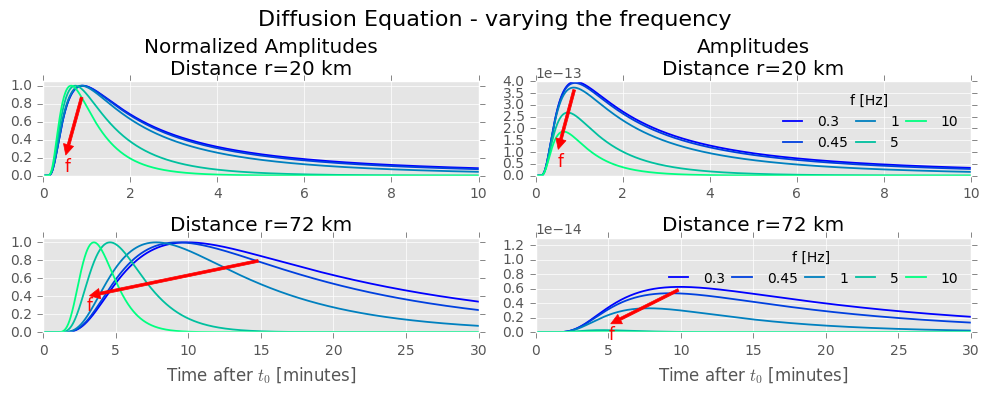

In [172]:
# show changes by frequency 
fig = plt.figure()
gs = gridspec.GridSpec(2,2)
# fig, ax = plt.subplots(figsize=(8, 4))

freqs = [0.3, 0.45, 1, 5, 10]

ax1 = fig.add_subplot(gs[0])

t = np.arange(0.5,3600*3)
colors = plt.cm.winter(np.linspace(0,1,len(freqs)))

for i, f in enumerate(freqs): 
    ax1.plot(t/60,diffusion_I(t,A=1,k=1.2e6,r=20*1000,f=f,Q=3600,
        normalized=True),color=colors[i],linewidth=1.3)

ax1.set_xlim(0,10)
ax1.set_ylim(0,1.05)
ax1.annotate('',xy=(0.5,0.2),xycoords='data',xytext =(0.9,0.9),
             arrowprops=opt,size=10)
ax1.text(0.5,0.2, 'f', fontsize=12, color='r',horizontalalignment='left',
    verticalalignment='top')
ax1.set_title('Normalized Amplitudes\nDistance r=20 km')

ax2 = fig.add_subplot(gs[1])

t = np.arange(0.5,3600*3)
colors = plt.cm.winter(np.linspace(0,1,len(freqs)))

for i, f in enumerate(freqs): 
    ax2.plot(t/60,diffusion_I(t,A=1,k=1.2e6,r=20*1000,f=f,Q=3600,
        normalized=False),color=colors[i],linewidth=1.3,label=str(f))

ax2.set_xlim(0,10)
ax2.annotate('',xy=(0.5,1e-13),xycoords='data',xytext =(0.9,3.75e-13),
             arrowprops=opt,size=10)
ax2.text(0.5,1e-13, 'f', fontsize=12, color='r',horizontalalignment='left',
    verticalalignment='top')
ax2.legend(ncol=3,prop={'size': 10},title=r'f [Hz]', framealpha=0,
           columnspacing=0.2)
ax2.set_title('Amplitudes\nDistance r=20 km')

ax3 = fig.add_subplot(gs[2])

t = np.arange(0.5,3600*3)
colors = plt.cm.winter(np.linspace(0,1,len(freqs)))

for i, f in enumerate(freqs): 
    ax3.plot(t/60,diffusion_I(t,A=1,k=1.2e6,r=72*1000,f=f,Q=3600,
        normalized=True),color=colors[i],linewidth=1.3)

ax3.set_xlim(0,30)
ax3.set_ylim(0,1.05)
ax3.annotate('',xy=(3,0.4),xycoords='data',xytext =(15,0.8),
             arrowprops=opt,size=10)
ax3.text(3,0.4, 'f', fontsize=12, color='r',horizontalalignment='left',
    verticalalignment='top')

ax3.set_xlabel(r'Time after $t_0$ [minutes]')
ax3.set_title('Distance r=72 km')

ax4 = fig.add_subplot(gs[3])

t = np.arange(0.5,3600*3)
colors = plt.cm.winter(np.linspace(0,1,len(freqs)))

for i, f in enumerate(freqs): 
    ax4.plot(t/60,diffusion_I(t,A=1,k=1.2e6,r=72*1000,f=f,Q=3600,
        normalized=False),color=colors[i],linewidth=1.3,label=str(f))
    
ax4.annotate('',xy=(5,0.1e-14),xycoords='data',xytext =(10,0.6e-14),
             arrowprops=opt,size=10)
ax4.text(5,0.1e-14, 'f', fontsize=12, color='r',horizontalalignment='left',
    verticalalignment='top')
ax4.legend(ncol=5,prop={'size': 10},title=r'f [Hz]', framealpha=0,
           columnspacing=0.2)
ax4.set_xlabel(r'Time after $t_0$ [minutes]')
ax4.set_title('Distance r=72 km')

ax4.set_xlim(0,30)
ax4.set_ylim(0,13e-15)

plt.suptitle('Diffusion Equation - Varying the Frequency', size=16)
gs.tight_layout(fig, rect=[0, 0, 1, 0.95])
plt.show()

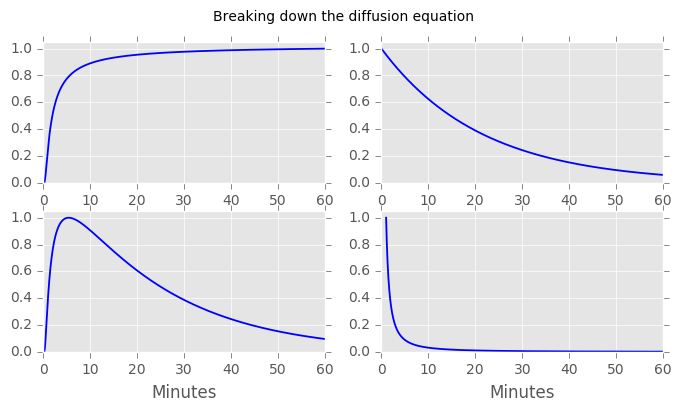

In [22]:
# which sections dominate? 
fig, ax = plt.subplots(figsize=(8, 4))

ax1 = plt.subplot(2, 2, 1)

t = np.arange(0.5,3600)
colors = plt.cm.winter(np.linspace(0,1,1))

ax1.plot(t/60,diffusion_I_first_term(t,A=1,k=1.2e6,r=20*1000,f=0.45,Q=3600,
    normalized=True),color=colors[0],linewidth=1.3)
ax1.set_ylim(0,1.05)

ax2 = plt.subplot(2, 2, 2)
ax2.plot(t/60,diffusion_I_second_term(t,A=1,k=1.2e6,r=20*1000,f=0.45,Q=3600,
    normalized=True),color=colors[0],linewidth=1.3)
ax2.set_ylim(0,1.05)

ax3 = plt.subplot(2, 2, 3)
ax3.plot(t/60,diffusion_I_exponent(t,A=1,k=1.2e6,r=20*1000,f=0.45,Q=3600,
    normalized=True),color=colors[0],linewidth=1.3)
ax3.set_ylim(0,1.05)
ax3.set_xlabel('Minutes')

ax4 = plt.subplot(2, 2, 4)
t = np.arange(60,3600)
ax4.plot(t/60,diffusion_I_outer(t,A=1,k=1.2e6,r=20*1000,f=0.45,Q=3600,
    normalized=True),color=colors[0],linewidth=1.3)
ax4.set_ylim(0,1.05)
ax4.set_xlabel('Minutes')
plt.suptitle('Breaking down the Diffusion Equation')
plt.show()

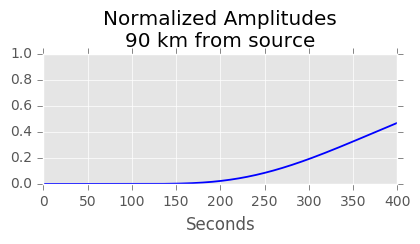

In [8]:
# 90 km from source - normalized - to compare with Glory's work 
fig, ax = plt.subplots(figsize=(8, 4))

ax2 = plt.subplot(2, 2, 2)
radii = [90]
# the direct arrival comes at t=22 s (before the diffuse arrival)

t = np.arange(0.05,3600)
colors = plt.cm.winter(np.linspace(0,1,len(radii)))
for i, r in enumerate(radii):
    r = r * 1000
    ax2.plot(t,diffusion_I(t,A=1,k=1.2e6,r=r,f=0.45,Q=3600,
    normalized=True),color=colors[i],linewidth=1.3)

ax2.set_xlim(0,400)
# ax2.set_ylim(0,0.05e-12)
ax2.set_xlabel('Seconds')
plt.title('Normalized Amplitudes\n90 km from source')
plt.tight_layout()

plt.show()